# Tested with colab

In [ ]:
pip install "git+https://github.com/greydanus/mnist1d.git@master"

In [ ]:
from mnist1d.data import make_dataset, get_dataset_args

defaults = get_dataset_args()
data = make_dataset(defaults)
x,y,t = data['x'], data['y'], data['t']

x.shape, y.shape, t.shape

((4000, 40), (4000,), (40,))

In [ ]:
from typing import Callable
from typing_extensions import Annotated
import numpy as np
from pydantic import (
    BaseModel,
    conint,
    confloat,
    Field,
    field_validator,
    BeforeValidator,
    ConfigDict,
    PlainSerializer
)

import jax.numpy as jnp


def nd_array_custom_before_validator(x):
    # custome before validation logic
    return x


def nd_array_custom_serializer(x):
    # custome serialization logic
    return str(x)
# From https://github.com/pydantic/pydantic/issues/7017
NdArray = Annotated[
    np.ndarray,
    BeforeValidator(nd_array_custom_before_validator),
    PlainSerializer(nd_array_custom_serializer, return_type=str),
]

class GraphParams(BaseModel):
    data: NdArray
    epsilon: confloat(gt=0) = None  # greater than 0, optional for epsilon graph
    k: conint(gt=0) = None  # greater than 0, optional for k-NN graphs
    sigma: confloat(gt=0) = 1.0  # greater than 0, default for Gaussian similarity
    model_config = ConfigDict(arbitrary_types_allowed=True)

    @field_validator('data')
    @classmethod
    def check_data(cls, v):
        if v.ndim != 2:
            raise ValueError("Data must be a 2-dimensional array")
        return v

def epsilon_graph(params: GraphParams, distance_func: Callable[[np.ndarray, np.ndarray], float]) -> np.ndarray:
    """
    Constructs an epsilon-neighborhood graph from given data points.
    """
    n = params.data.shape[0]
    graph = np.zeros((n, n), dtype=int)
    for i in range(n):
        for j in range(i + 1, n):
            if distance_func(params.data[i], params.data[j]) < params.epsilon:
                graph[i][j] = graph[j][i] = 1
    return graph

def k_nearest_neighbor_graph(params: GraphParams, distance_func: Callable[[np.ndarray, np.ndarray], float]) -> np.ndarray:
    """
    Constructs a k-nearest neighbor graph from given data points.
    """
    n = params.data.shape[0]
    graph = np.zeros((n, n), dtype=int)
    distances = np.zeros((n, n), dtype=float)

    data = params.data

    point_differences = data[:, np.newaxis, :] - data[np.newaxis, :, :]
    distances = np.linalg.norm(point_differences, axis=-1)

    print(distances.shape)

    for i in range(n):
        nearest_neighbors = np.argsort(distances[i])[:params.k + 1]
        for neighbor in nearest_neighbors:
            if i != neighbor:
                graph[i][neighbor] = 1
    return graph

def mutual_k_nearest_neighbor_graph(params: GraphParams, distance_func: Callable[[np.ndarray, np.ndarray], float]) -> np.ndarray:
    """
    Constructs a mutual k-nearest neighbor graph from given data points.
    """
    n = params.data.shape[0]
    k_nn_graph = k_nearest_neighbor_graph(params, distance_func)
    mutual_graph = np.zeros((n, n), dtype=int)
    for i in range(n):
        for j in range(n):
            if k_nn_graph[i][j] and k_nn_graph[j][i]:
                mutual_graph[i][j] = mutual_graph[j][i] = 1
    return mutual_graph

def fully_connected_graph(params: GraphParams, similarity_func: Callable[[np.ndarray, np.ndarray], float]) -> np.ndarray:
    """
    Constructs a fully connected graph from given data points.
    """
    n = params.data.shape[0]
    graph = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            similarity = similarity_func(params.data[i], params.data[j], sigma=params.sigma)
            graph[i][j] = graph[j][i] = similarity
    return graph

# Example functions retained as before:
def euclidean_distance(x: np.ndarray, y: np.ndarray) -> float:
    return np.linalg.norm(x - y)

def gaussian_similarity(x: np.ndarray, y: np.ndarray, sigma: float) -> float:
    return np.exp(-np.linalg.norm(x - y)**2 / (2 * sigma**2))


params = GraphParams(
    data=x,
    k=4
)

#diff = k_nearest_neighbor_graph(params, euclidean_distance)

In [ ]:
#params.data
data = jnp.asarray(params.data)
# Perform
W = jnp.linalg.norm(data[:, jnp.newaxis, :] - data[jnp.newaxis, :, :], axis=-1)

# Sum rows
D = W.sum(axis=0)

L_rw = jnp.diag(1 / D) @ W

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format='retina'

In [ ]:
import pandas as pd
df_random_walk = pd.DataFrame()
df_random_walk["transition_probability"] = L_rw[0]
df_random_walk["class"] = y

In [ ]:
df_random_walk

,transition_probability,class
0,0.000000,2
1,0.000361,6
2,0.000201,4
3,0.000139,5
4,0.000343,6
...,...,...
3995,0.000307,6
3996,0.000290,8
3997,0.000155,5
3998,0.000176,4


In [ ]:
y[0]

2

# Euclidian similarity seems to capture some trends, but it's not correctly capturing the label of the example, which is 2

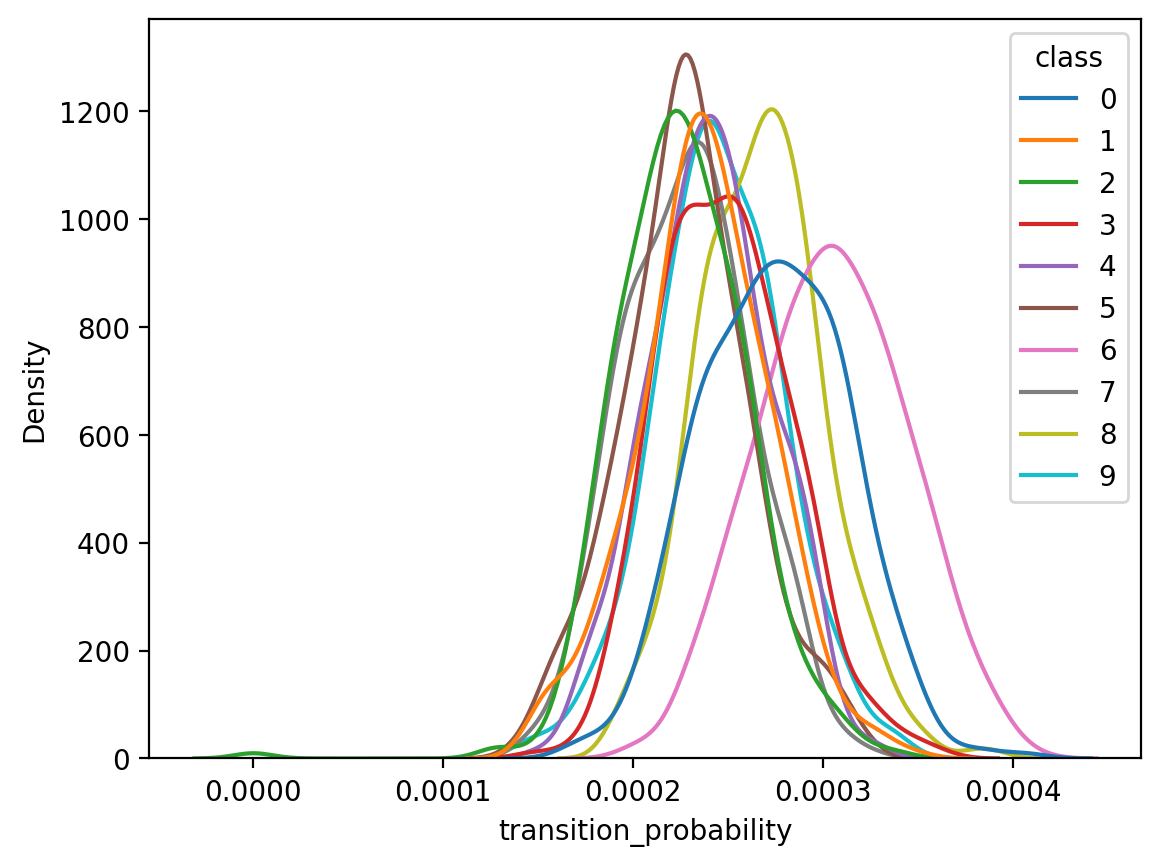

In [ ]:
_ = sns.kdeplot(data=df_random_walk, x="transition_probability", hue="class", palette=sns.color_palette())

In [ ]:
K = 10

In [ ]:
Lambdas, V = np.linalg.eig(L_rw)
# Sort the eigenvalues by their L2 norms and record the indices


In [ ]:
K = 10 # number of clusters
sorted_indices = np.argsort(np.abs(Lambdas))

V_K = np.real(V[:, sorted_indices[:K]])

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=K, init='k-means++', random_state=0).fit(V_K)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
from sklearn import metrics

In [ ]:
y_pred = kmeans.labels_
y_true = y


Doesn't capture the clusters
- Fully connected euclidean distance similarity matrix
- Random walk Laplacian
- Standard SVD for eigenvalues
- kmeans


In [ ]:

metrics.rand_score(y_true, y_pred)

0.10458089522380595

In [ ]:
# !!
metrics.adjusted_rand_score(y_true, y_pred)

-5.350681183855522e-06

In [ ]:
metrics.adjusted_mutual_info_score(y_true, y_pred)

0.0004974610202823368

(array([398., 396., 411., 394., 394., 402., 401., 404., 402., 398.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

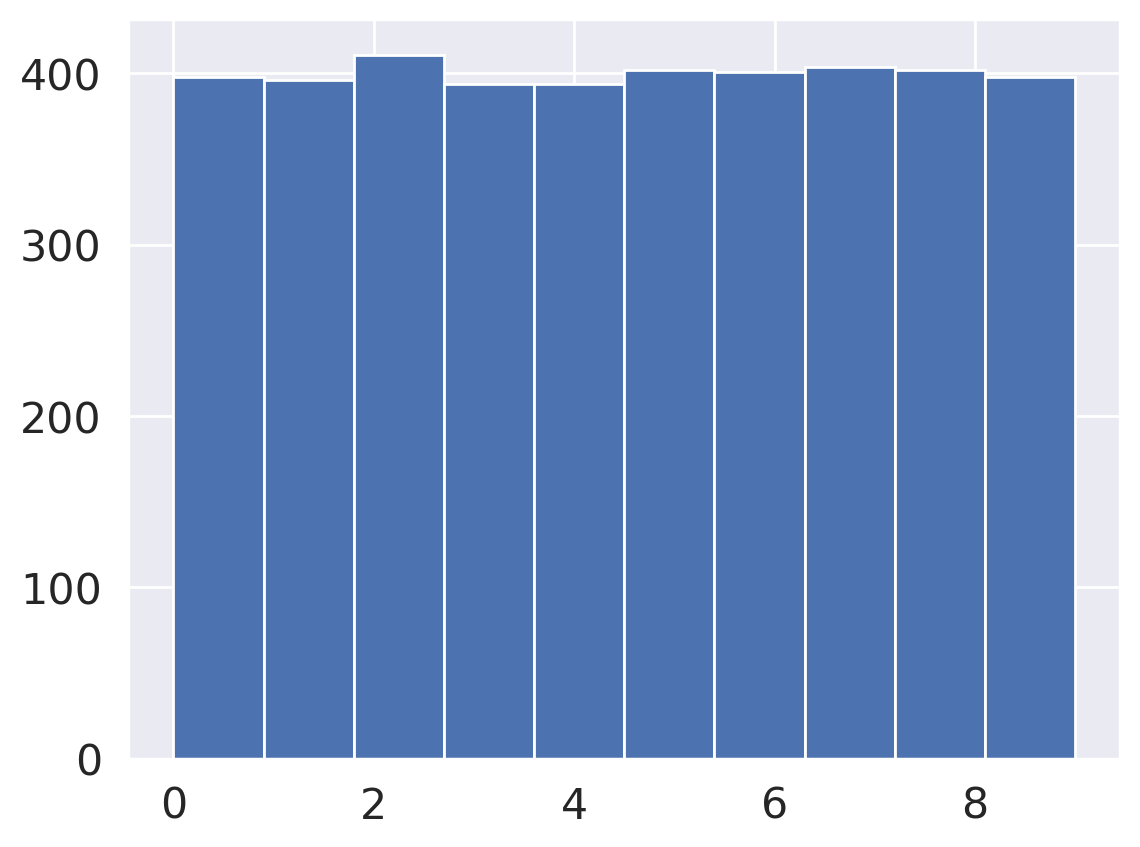

In [ ]:
plt.hist(y_true)

# Clustering is collapsing into 1 cluster, as a next step we should inspect what is making the samples that don't collapse into 0 different
# or try a different similarity matrix like meila-shi, which make image segmentation, which should work for 1d mnist

0    3988
6       2
7       2
4       2
5       1
3       1
8       1
9       1
2       1
1       1
Name: count, dtype: int64

(array([3.988e+03, 1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        2.000e+00, 2.000e+00, 1.000e+00, 1.000e+00]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

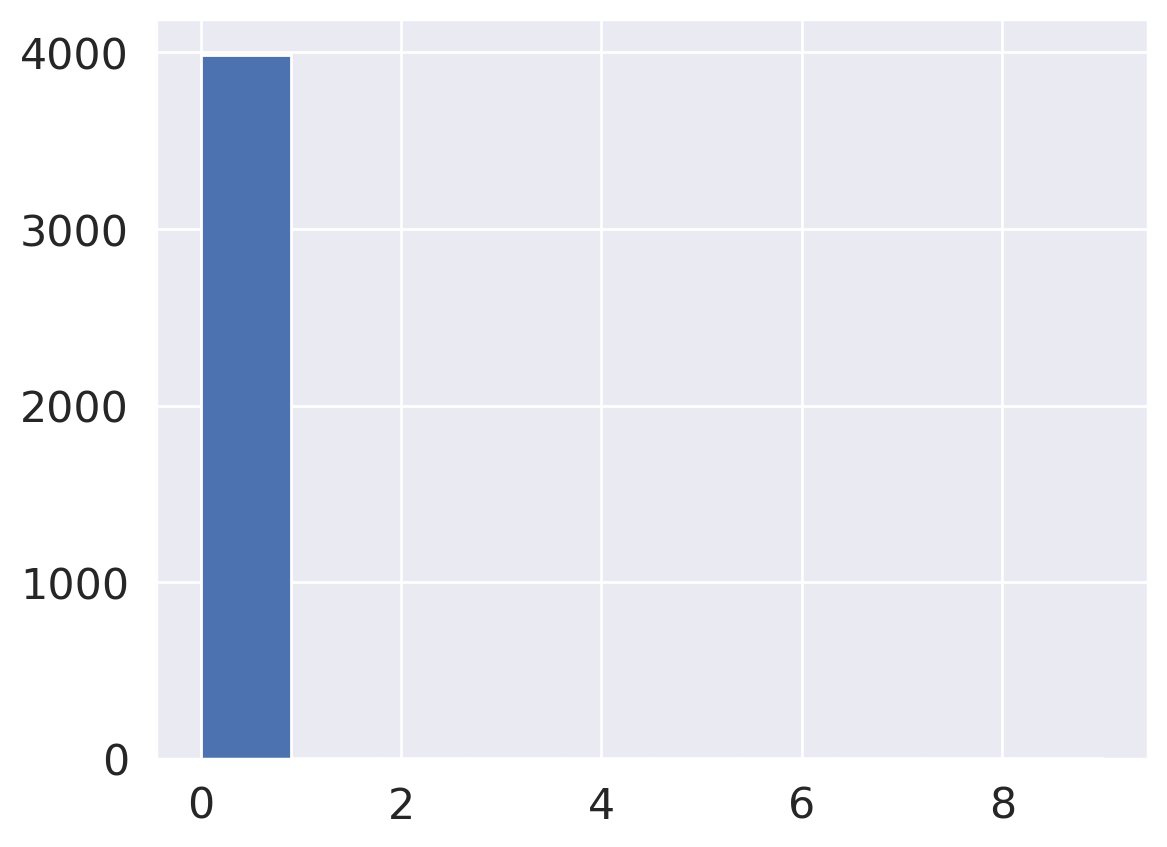

In [ ]:
display(pd.Series(y_pred).value_counts())
plt.hist(y_pred)

In [ ]:
# Ignores permutations
metrics.rand_score([0, 0, 1, 1], [1, 1, 0, 0])

1.0

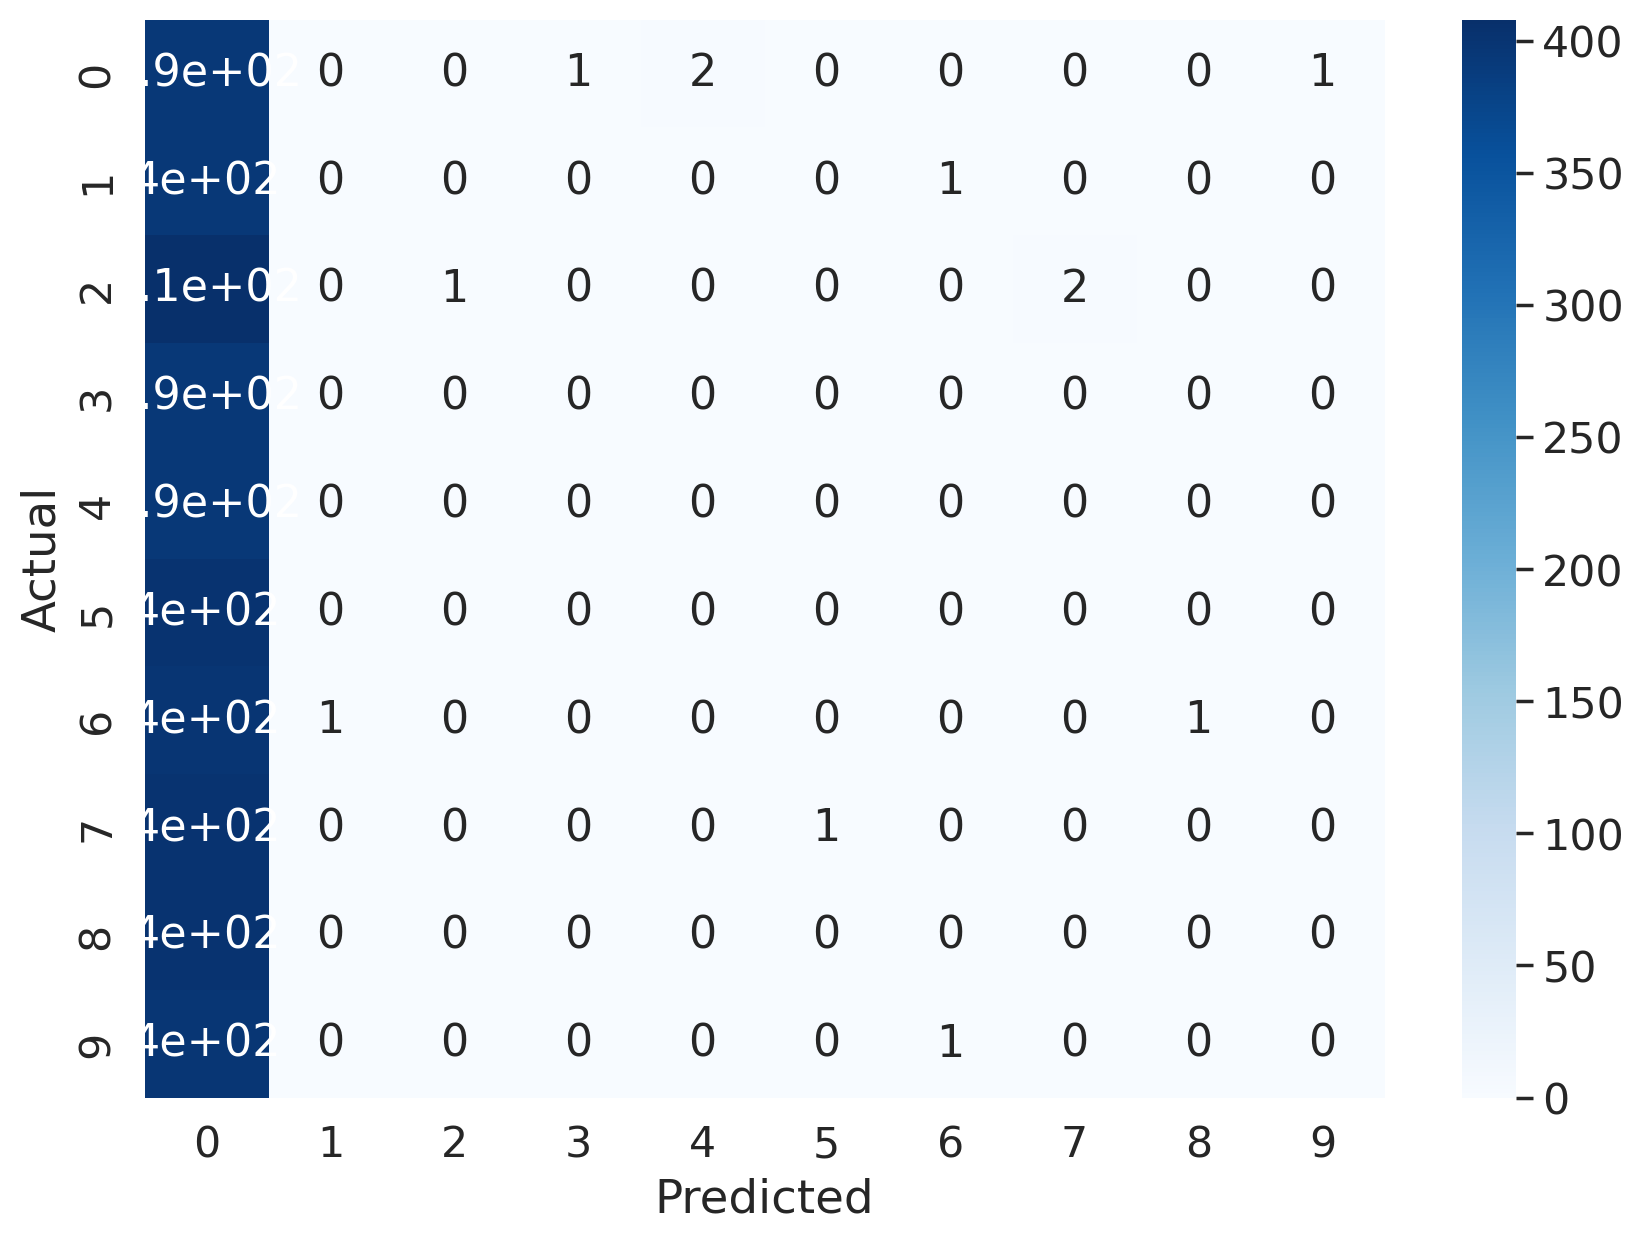

In [ ]:
if y_true is not None:
    data = metrics.confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

# 1D MNIST

In [ ]:
# Check if JAX is using the GPU
from jax.lib import xla_bridge
if xla_bridge.get_backend().platform != "gpu":
    raise ValueError("Not using the GPU")